# Train ⭐ CellNet ⭐ on Point Heatmaps

In [1]:

import sys; sys.path += [".."]  # NOTE find shared modules
import os 

from util.preprocess import *
from util.plot import *

import skimage, scipy
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

INTERACTIVE = not torch.cuda.is_available()
if not INTERACTIVE: plot_set_scale(4)

print(f"Device: {device}")

Device: cuda:0


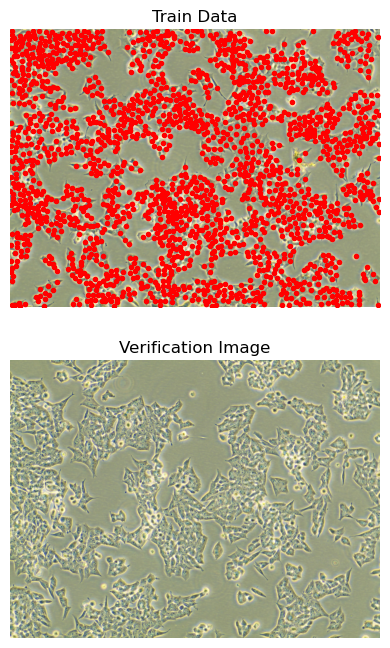

In [2]:

norm = lambda x: (x - x.min()) / (x.max() - x.min())

# load as channel and move to device
load_image = lambda i: norm(torch.from_numpy(skimage.io.imread(f"../data/third/{i}.jpg")).float()).permute(2,0,1).unsqueeze(0).to(device)


X_train, X_verif = [load_image(i) for i in [1,2]]
P_train = preprocess_point("../data/third/points-plus.json", dtype=float, unique=True, device=device)

if INTERACTIVE: 
  s = 512
  X_train, X_verif = [X[...,:s,:s] for X in [X_train, X_verif]]
  P_train = P_train[P_train[:,1] < s] 
  P_train = P_train[P_train[:,0] < s] 

plot_set_shape(X_train.shape[:2])
_, (a,b) = mk_fig(1,2)

plot_image(X_train, ax=a, title=f"Train Data")
plot_point(P_train, ax=a, c='r')

plot_image(X_verif, ax=b, title=f"Verification Image");

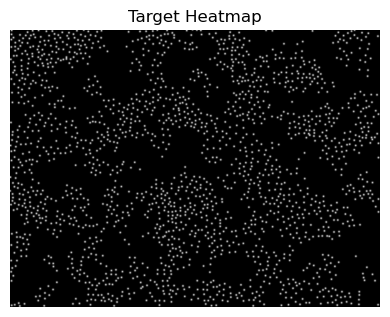

In [3]:

# draw small gaussians at every point
Y_train = np.zeros(X_train.shape[2:])
Y_train[..., (p:=P_train.int().cpu().numpy())[:,1], p[:,0]] = 1   # NOTE: when used to index arrays Y and X need to be swapped
Y_train = norm(skimage.filters.gaussian(Y_train, sigma=3.5, mode='constant'))
Y_train = torch.from_numpy(Y_train).unsqueeze(0).unsqueeze(0).float().to(device)

Y2heat= lambda Y: torch.stack([ y:=Y[0,0], z:=torch.zeros_like(y), z,y])

plot_image(Y_train, title=f"Target Heatmap");

#ax = plot_image(X_train, title=f"Target Heatmap on Train Image");
#plot_image(Y2heatmap(Y_train), ax=ax)

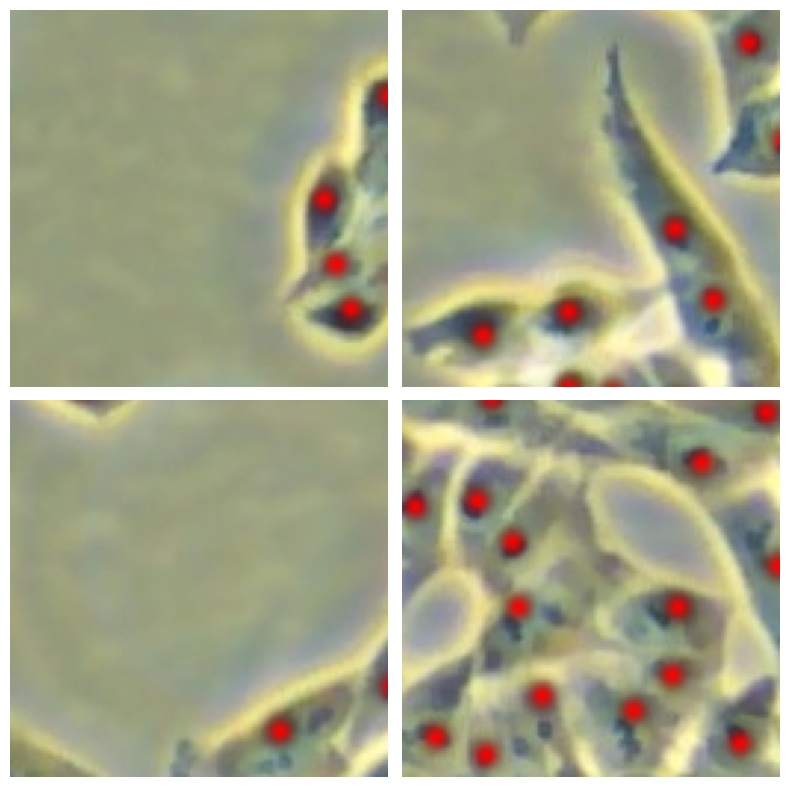

In [4]:

def sample_tile(X, Y, size):
  """Sample a tile of size `size` from the image X and the mask Y"""
  b,c,h,w = X.shape
  x = np.random.randint(0, w - size)
  y = np.random.randint(0, h - size)
  return X[..., y:y+size, x:x+size], Y[..., y:y+size, x:x+size]

def batch_tiles(X, Y, size, n):
  """Sample n tiles of size `size` from the image X and the mask Y"""
  Xs, Ys = zip(*[sample_tile(X, Y, size) for _ in range(n)])
  return torch.cat(Xs), torch.cat(Ys)


tile_size = 128
fig, axs = mk_fig(2,2,shape=(1,1))
Xs, Ys = batch_tiles(X_train, Y_train, tile_size, 4)
for ax, X,Y in zip(axs, Xs, Ys):
  heat = torch.stack([Y[0], Z:=torch.zeros_like(Y[0]), Z, Y[0]], axis=-1)
  
  plot_image(X, ax=ax)
  plot_image(heat, ax=ax)

In [5]:
# UnetPlusPlus with mobileone_s4 took about 7m49s for 51 epochs on 512 slice on laptop for shitty results
# Unet with resnet34 took 1.35 for reasonable results
model = smp.Unet(
  encoder_name="resnet34",
  encoder_weights=None,
  in_channels=3,
  classes=1,
  activation='sigmoid',
)
model.to(device)

model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

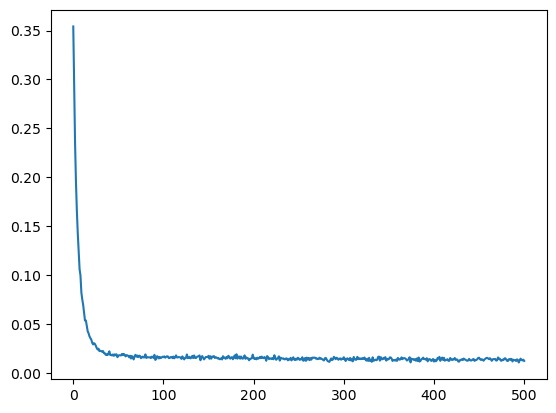

In [6]:

# train the model in a simple pytorch loop
SNAPSHOTS = []

n_epochs = 501 if not INTERACTIVE else 51
batch_size = 32 if not INTERACTIVE else 8

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
criterion = torch.nn.MSELoss()
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=8, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.5)

model.train()

for epoch in range(n_epochs):
  model.train()
  optimizer.zero_grad()

  X,Y = batch_tiles(X_train, Y_train, tile_size, batch_size)

  Z = model(X)
  loss = criterion(Z, Y)

  loss.backward()
  optimizer.step()

  if epoch % 1 == 0:
    with torch.no_grad():
      model.eval()
      Z_train = model(X_train)
      Z_verif = model(X_verif)

      SNAPSHOTS.append(dict(
        epoch = epoch,
        loss = loss.item(),
        lr = optimizer.param_groups[0]['lr'],
        Z_train = Z_train[[0]].detach().cpu(),
        Z_verif = Z_verif[[0]].detach().cpu(),
      ))

  
  scheduler.step()#(loss.item())

plt.plot(np.array([x['loss'] for x in SNAPSHOTS]))

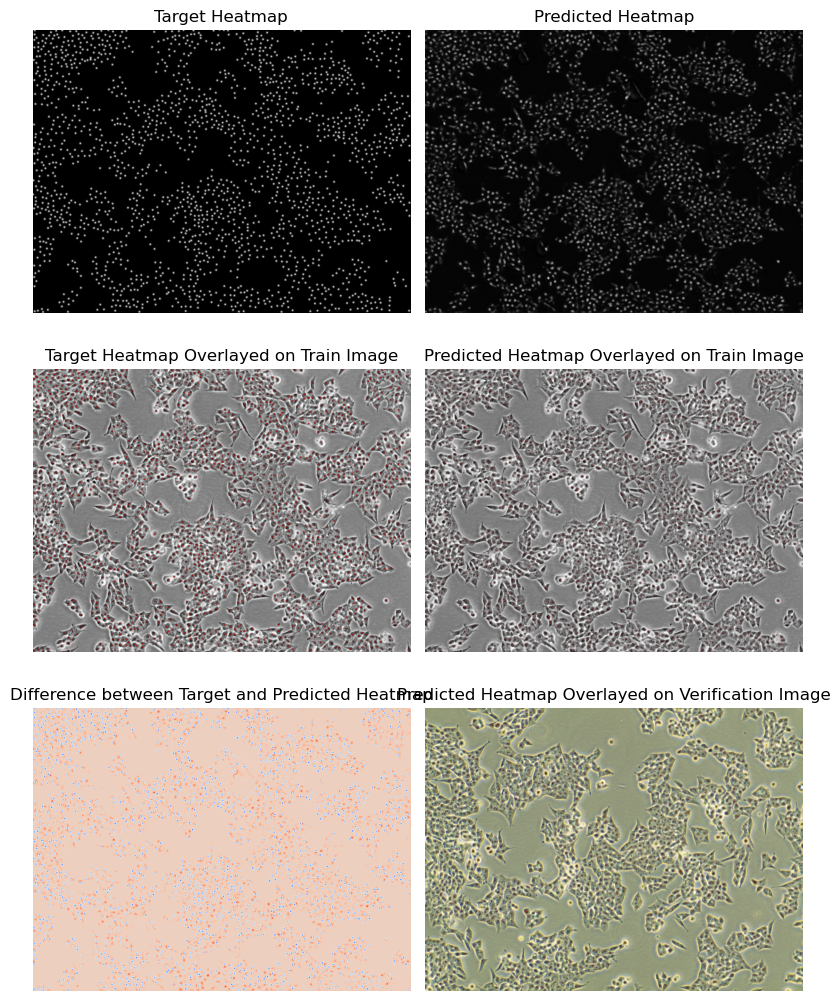

In [7]:

model.eval()
with torch.no_grad():
  Z_train = model(X_train)
  Z_verif = model(X_verif)

fig, axs = mk_fig(2,3)

X = X_train[:,[1],...]  # green channel which is the sharpest 
 
plot_image(Y_train, ax=axs[0], title=f"Target Heatmap")
plot_image(Z_train, ax=axs[1], title=f"Predicted Heatmap")

def plot_heatmap_overlay(X, Y, ax, title):
  plot_image(X, ax=ax)
  plot_image(Y2heat(Y), ax=ax, title=title)

plot_heatmap_overlay(X, Y_train, ax=axs[2], title=f"Target Heatmap Overlayed on Train Image")
plot_heatmap_overlay(X, Z_train, ax=axs[3], title=f"Predicted Heatmap Overlayed on Train Image")

plot_image(Z_train-Y_train, ax=axs[4], cmap='coolwarm', title=f"Difference between Target and Predicted Heatmap")

plot_heatmap_overlay(X_verif, Z_verif, ax=axs[5], title=f"Predicted Heatmap Overlayed on Verification Image")

In [8]:

from IPython import display
from matplotlib.animation import FuncAnimation, FFMpegWriter

os.system("module load ffmpeg || echo 'could not: module load ffmpeg - are you on HPC?'")

fig, (a, b) = mk_fig(2,1, shape=Y_train.shape[-2:])  # note 90° rotation
Xt = X.permute(0,1,3,2)  # rotate
Xv = X_verif[:,[1],...].permute(0,1,3,2)  # rotate

n_frames = len(SNAPSHOTS)

logify = False
B,C,H,W = Y_train.shape
W,H = H,W  # rotate

scalars = { dim: (
  y := np.array([x[dim] for x in SNAPSHOTS]),
  y := np.log(y) if logify else y,
  m := y.min() if logify else 0,
  H - (y - m) / (y.max() - m) * H
  )[-1]
  
  for dim in ['loss', 'lr']
}

def animate(i):
  epoch, Zt, Zv = [SNAPSHOTS[i][k] for k in 'epoch Z_train Z_verif'.split()]
  Zt, Zv = [z.permute(0,1,3,2) for z in (Zt, Zv)]  # note 90° rotation to fit two wide images next to each other

  [ax.clear() for ax in [a,b]]
  
  plot_heatmap_overlay(Xt, Zt, ax=a, title=f"Predicted Heatmap Overlayed on Train Image")
  plot_heatmap_overlay(Xv, Zv, ax=b, title=f"Predicted Heatmap Overlayed on Verification Image")

  xs = np.linspace(0, W*(i-1)/n_frames, i)
  for k,v in scalars.items():
    a.plot(xs, v[:i], label=f"{'log' if logify else ''} {k}")

  a.legend(loc='upper right');


anim = FuncAnimation(fig, animate, frames=n_frames, interval=100)
 
if not INTERACTIVE:  
  writervideo = FFMpegWriter(fps=30) 
  anim.save('../runs/smp/cellnet/training-convergence-1.mp4', writer=writervideo) 

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

<Axes: title={'center': 'Point Spread Function - Guassuan σ = 3.5 '}>

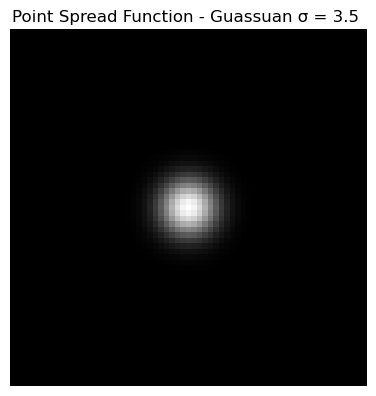

In [9]:
from scipy import fftpack

# the psf is a gaussian with sigma from above = 3.5

ks = 65  # needs to be uneven
psf = np.zeros((ks,ks))
psf[ks//2,ks//2] = 1
psf = skimage.filters.gaussian(psf, sigma=3.5, mode='constant')

plot_image(psf, title=f"Point Spread Function - Guassuan σ = 3.5 ")

## Deconvolution from Gauss to Points (?)
- Wiener worked only so bad that I was not able to restore the points from the target heatmap with different balance factors. 
- unsupervised Wiener failed same
- Analytical / Naiive approach with division in Fourier space failed... but is also very noise affected according to the internet 

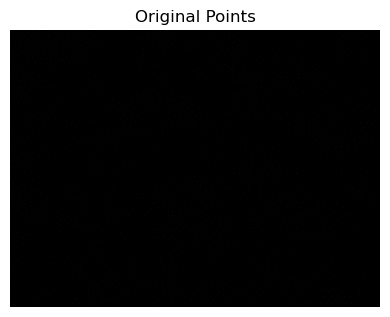

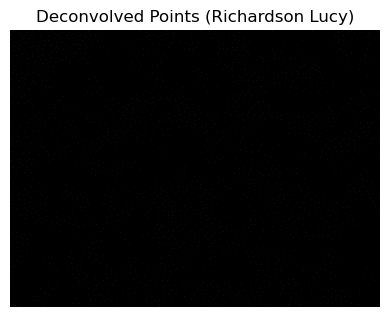

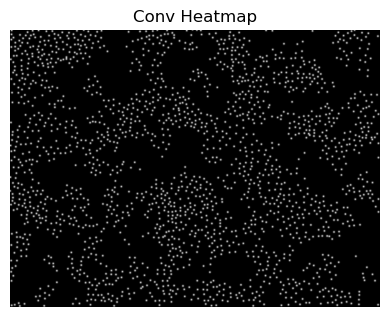

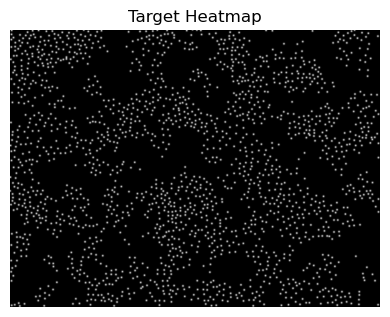

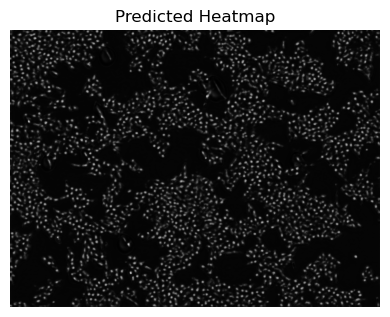

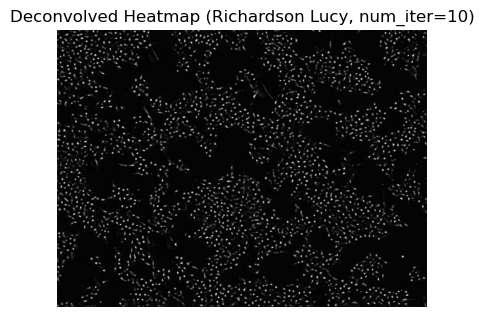

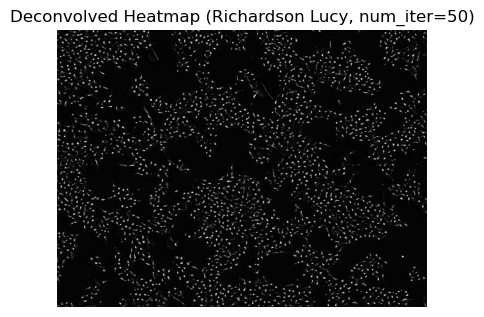

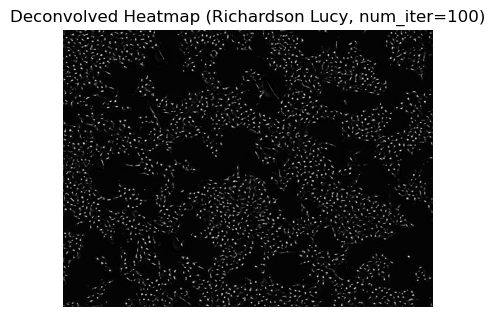

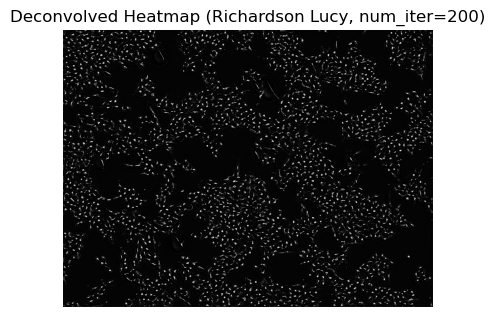

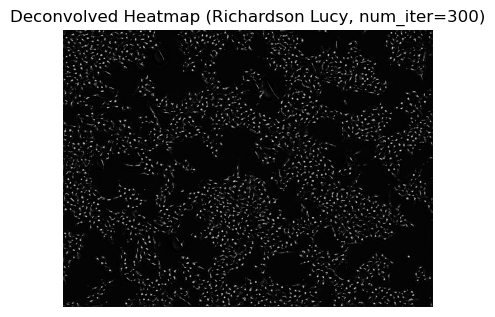

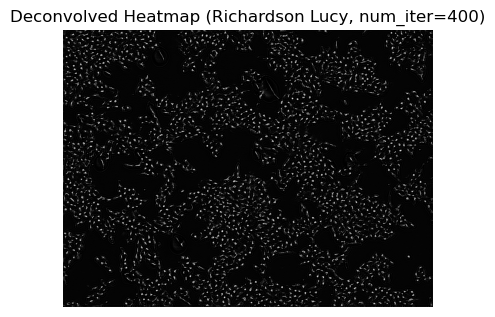

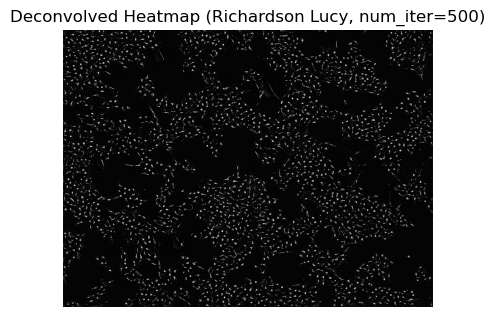

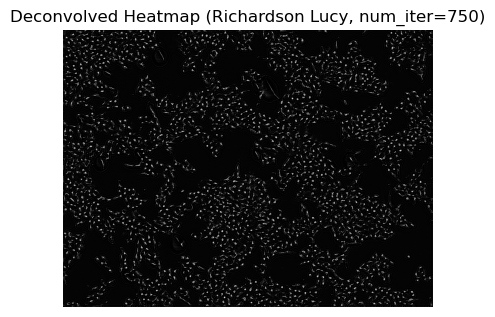

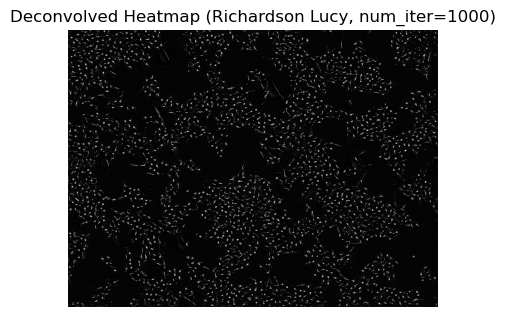

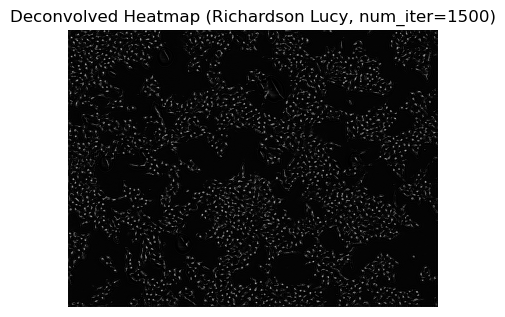

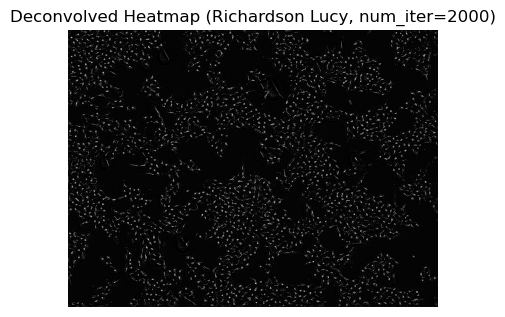

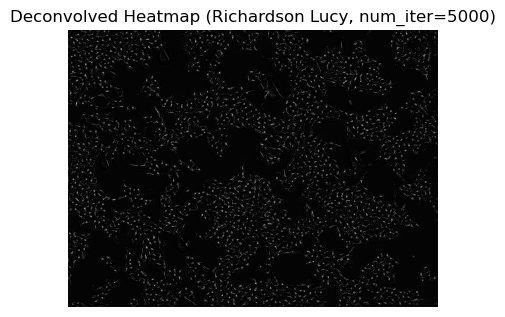

In [10]:

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration


Q_train = np.zeros(X_train.shape[-2:])
Q_train[(p:=P_train.int().cpu().numpy())[:,1], p[:,0]] = 1 
Y_train_ = conv2(Q_train, psf, 'same')

plot_image(Q_train, title=f"Original Points")

Q_train_ = restoration.richardson_lucy(Y_train_, psf, num_iter=500)
plot_image(Q_train_, title=f"Deconvolved Points (Richardson Lucy)")

plot_image(Y_train_, title=f"Conv Heatmap")
plot_image(Y_train, title=f"Target Heatmap")
plot_image(Z_train, title=f"Predicted Heatmap")

for num_iter in [10,50,100,200,300,400,500,750,1000,1500,2000,5000]:
  R_train = restoration.richardson_lucy(Z_train[0,0].cpu().numpy(), psf, num_iter=num_iter)
  plot_image(R_train, title=f"Deconvolved Heatmap (Richardson Lucy, num_iter={num_iter})")